In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import ipywidgets as widgets
from IPython.html.widgets import *
import pickle
import h5py 




%matplotlib inline

/home/aras/Desktop/commaAI/jovsa_venv/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [1]:
! which python


/home/aras/Desktop/commaAI/jovsa_venv/bin/python


In [3]:
# constants
DATA_PATH = '/home/aras/Desktop/commaAI/speed_challenge_2017/data'
TRAIN_VIDEO = os.path.join(DATA_PATH, 'train.mp4')
TEST_VIDEO = os.path.join(DATA_PATH, 'test.mp4')
CLEAN_DATA_PATH = '/home/aras/Desktop/commaAI/speed_challenge_2017/clean_data'
CLEAN_IMGS_TRAIN = os.path.join(CLEAN_DATA_PATH, 'train_imgs')
CLEAN_IMGS_TEST = os.path.join(CLEAN_DATA_PATH, 'test_imgs')

train_frames = 8616 #20400 #8616
test_frames = 10798

seeds = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144]


In [4]:
train_meta = pd.read_csv(os.path.join(CLEAN_DATA_PATH, 'train_meta.csv')) #train2_meta
print('shape: ', train_meta.shape)

shape:  (20400, 3)


In [5]:
# note: there is a chance that points might appear again. as n

def train_valid_split(dframe, seed_val):
    """
    Randomly shuffle pairs of rows in the dataframe, separates train and validation data
    generates a uniform random variable 0->9, gives 20% chance to append to valid data, otherwise train_data
    return tuple (train_data, valid_data) dataframes
    """
    train_data = pd.DataFrame()
    valid_data = pd.DataFrame()
    np.random.seed(seed_val)
    for i in tqdm(range(len(dframe) - 1)):
        idx1 = np.random.randint(len(dframe) - 1)
        idx2 = idx1 + 1
        
        
        row1 = dframe.iloc[[idx1]].reset_index()
        row2 = dframe.iloc[[idx2]].reset_index()
        
        randInt = np.random.randint(9)
        if 0 <= randInt <= 1:
            valid_frames = [valid_data, row1, row2]
            valid_data = pd.concat(valid_frames, axis = 0, join = 'outer', ignore_index=False)
        if randInt >= 2:
            train_frames = [train_data, row1, row2]
            train_data = pd.concat(train_frames, axis = 0, join = 'outer', ignore_index=False)
    return train_data, valid_data

In [7]:
train_data, valid_data = train_valid_split(train_meta, seeds[0])

100%|██████████| 20399/20399 [00:47<00:00, 430.49it/s]


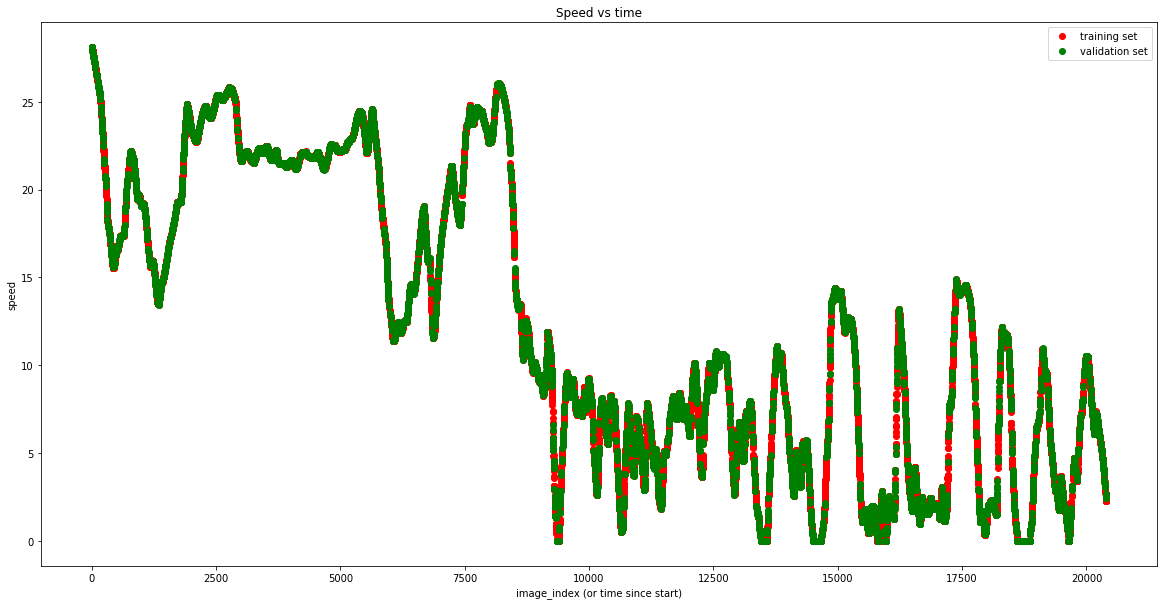

----
valid_data:  (9032, 4)
train_data:  (31766, 4)


In [206]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train_data.sort_values(['image_index'])[['image_index']], train_data.sort_values(['image_index'])[['speed']], 'ro')
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], valid_data.sort_values(['image_index'])[['speed']], 'go')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Speed vs time')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.close()

print('----')
print('valid_data: ', valid_data.shape)
print('train_data: ', train_data.shape)

In [44]:
def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

In [296]:
def opticalFlowDense(image_current, image_next):
    """
    input: image_current, image_next (RGB images)
    calculates optical flow magnitude and angle and places it into HSV image
    * Set the saturation to the saturation value of image_next
    * Set the hue to the angles returned from computing the flow params
    * set the value to the magnitude returned from computing the flow params
    * Convert from HSV to RGB and return RGB image with same size as original image
    """
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    
    hsv = np.zeros((66, 220, 3))
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]
 
    # Flow Parameters
#     flow_mat = cv2.CV_32FC2
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current, gray_next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)


    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # hue corresponds to direction
    hsv[:,:,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
  
    # convert HSV to float32'
    hsv = np.asarray(hsv, dtype= np.float32)
    
    
    rgb_ang = hsv.copy()
    rgb_ang[:,:,1] = 255    
    rgb_ang[:,:,2] = 255    

    rgb_ang = cv2.cvtColor(rgb_ang,cv2.COLOR_HSV2RGB)

    print('flow image(only ang):', rgb_ang.shape)
    plt.imshow(rgb_ang)
    plt.show()
    plt.close()
    
    rgb_mag = hsv.copy() 
    rgb_mag[:,:,0] = 255
    rgb_mag[:,:,1] = 255
    rgb_mag = cv2.cvtColor(rgb_mag,cv2.COLOR_HSV2RGB)

    print('flow image(only mag):', rgb_mag.shape)
    plt.imshow(rgb_mag)
    plt.show()
    plt.close()
    
    rgb_sat = hsv.copy() 
    rgb_sat[:,:,0] = 255
    rgb_sat[:,:,2] = 255
    rgb_sat = cv2.cvtColor(rgb_sat,cv2.COLOR_HSV2RGB)

    print('flow image(only saturation):', rgb_sat.shape)
    plt.imshow(rgb_sat)
    plt.show()
    plt.close()
    
    
    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    
    return rgb_flow

In [297]:
def preprocess_image(image):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (220, 66, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             3) resize to (220, 66, 3) if not done so already from perspective transform
    """
    # Crop out sky (top) (100px) and black right part (-90px)
    #image_cropped = image[100:440, :-90] # -> (380, 550, 3) #v2 for data
    image_cropped = image[25:375, :] #v1 for data
    
    image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
    return image

original image shape: (480, 640, 3)


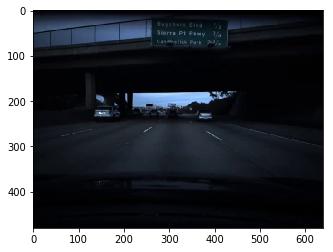

post prosessed image: (66, 220, 3)


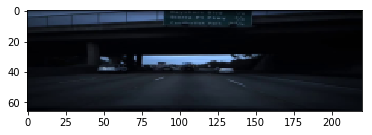

In [298]:
img=mpimg.imread(train_meta['image_path'][10])
print('original image shape:', img.shape)
plt.imshow(img)
plt.show()
plt.close()

post_img = preprocess_image(img)
print('post prosessed image:', post_img.shape)
plt.imshow(post_img)
plt.show()
plt.close()

In [299]:
def preprocess_image_valid_from_path(image_path, speed):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)
    return img, speed

def preprocess_image_from_path(image_path, speed, bright_factor):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = change_brightness(img, bright_factor)    
    img = preprocess_image(img)
    return img, speed

In [300]:
def generate_training_data(data, batch_size = 32):
    image_batch = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            # generate a random index with a uniform random distribution from 1 to len - 1
            idx = np.random.randint(1, len(data) - 1)
            
            # Generate a random bright factor to apply to both images
            bright_factor = 0.2 + np.random.uniform()
            
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['image_index'].values[0]
            time_prev = row_prev['image_index'].values[0]
            time_next = row_next['image_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
                
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')            
            
            x1, y1 = preprocess_image_from_path(row1['image_path'].values[0],
                                                row1['speed'].values[0],
                                               bright_factor)
            
            # preprocess another image
            x2, y2 = preprocess_image_from_path(row2['image_path'].values[0], 
                                                row2['speed'].values[0],
                                               bright_factor)
           
            # compute optical flow send in images as RGB
            rgb_diff = opticalFlowDense(x1, x2)
                        
            # calculate mean speed
            y = np.mean([y1, y2])
            
            image_batch[i] = rgb_diff
            label_batch[i] = y
        
        #print('image_batch', image_batch.shape, ' label_batch', label_batch)
        # Shuffle the pairs before they get fed into the network
        yield shuffle(image_batch, label_batch)

In [301]:
def generate_validation_data(data):
    while True:
        for idx in range(1, len(data) - 1): # start from the second row because we may try to grab it and need its prev to be in bounds
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['image_index'].values[0]
            time_prev = row_prev['image_index'].values[0]
            time_next = row_next['image_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
                
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')        
            
            x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0], row1['speed'].values[0])
            x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], row2['speed'].values[0])
            
            
            
            
            img=mpimg.imread(row1['image_path'].values[0])
            print('original1 image shape:', img.shape)
            plt.imshow(img)
            plt.show()
            plt.close()
            
            img=mpimg.imread(row2['image_path'].values[0])
            print('original2 image shape:', img.shape)
            plt.imshow(img)
            plt.show()
            plt.close()
            
            print('processed1 image shape:', x1.shape)
            plt.imshow(x1)
            plt.show()
            plt.close()
           
            print('processed2 image shape:', x2.shape)
            plt.imshow(x2)
            plt.show()
            plt.close()
            
            
            img_diff = opticalFlowDense(x1, x2)

            
            print('rgb that gets fed to NN image:', img_diff.shape)
            plt.imshow(img_diff)
            plt.show()
            plt.close()

        
            img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
            y = np.mean([y1, y2])
            
            speed = np.array([[y]])
            
            #print('img_diff', img_diff.shape, ' speed', speed)
            yield img_diff, speed

In [302]:
valid_generator = generate_validation_data(valid_data)
val_size = len(valid_data.index)

train_size = len(train_data.index)
train_generator = generate_training_data(train_data)

In [303]:
type(train_generator)

generator

original1 image shape: (480, 640, 3)


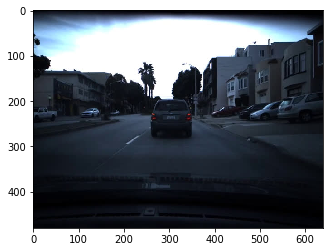

original2 image shape: (480, 640, 3)


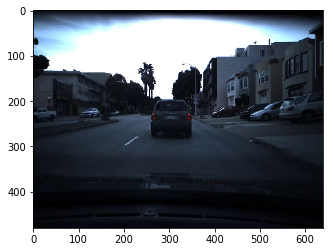

processed1 image shape: (66, 220, 3)


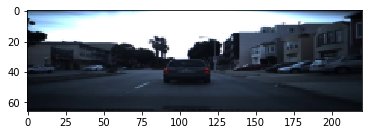

processed2 image shape: (66, 220, 3)


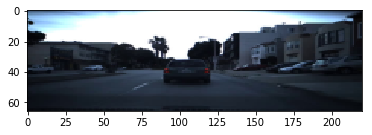

flow image(only ang): (66, 220, 3)


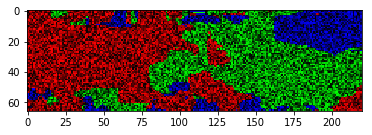

flow image(only mag): (66, 220, 3)


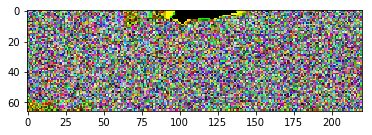

flow image(only saturation): (66, 220, 3)


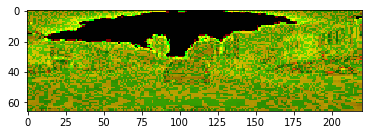

rgb that gets fed to NN image: (66, 220, 3)


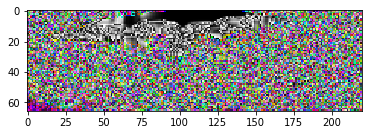

original1 image shape: (480, 640, 3)


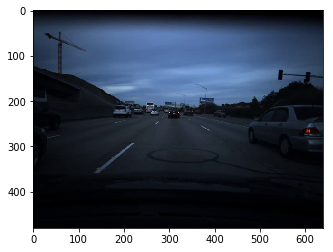

original2 image shape: (480, 640, 3)


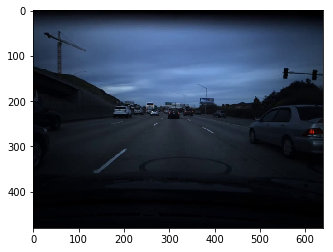

processed1 image shape: (66, 220, 3)


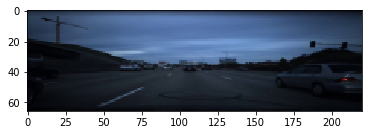

processed2 image shape: (66, 220, 3)


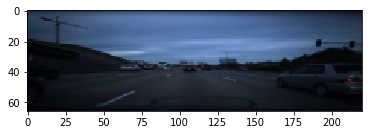

flow image(only ang): (66, 220, 3)


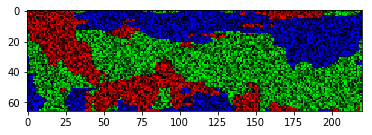

flow image(only mag): (66, 220, 3)


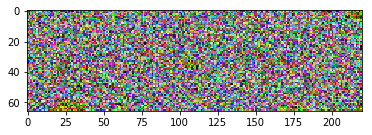

flow image(only saturation): (66, 220, 3)


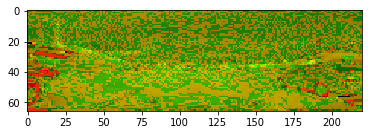

rgb that gets fed to NN image: (66, 220, 3)


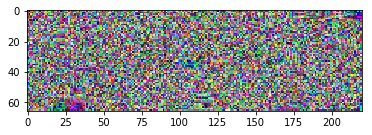

original1 image shape: (480, 640, 3)


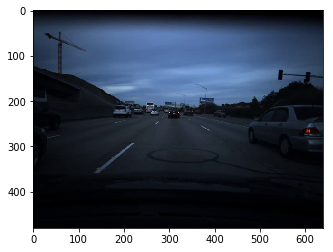

original2 image shape: (480, 640, 3)


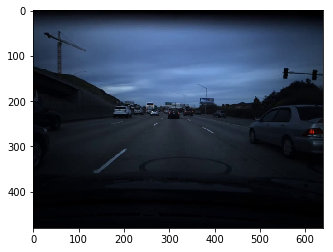

processed1 image shape: (66, 220, 3)


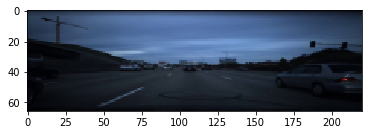

processed2 image shape: (66, 220, 3)


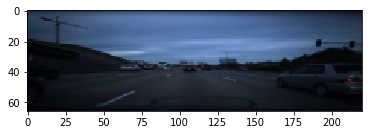

flow image(only ang): (66, 220, 3)


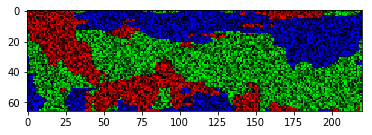

flow image(only mag): (66, 220, 3)


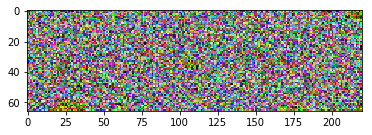

flow image(only saturation): (66, 220, 3)


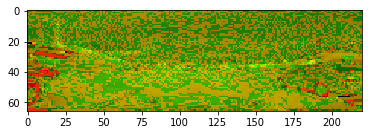

rgb that gets fed to NN image: (66, 220, 3)


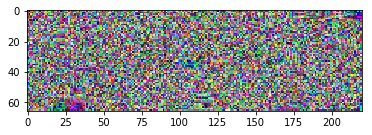

original1 image shape: (480, 640, 3)


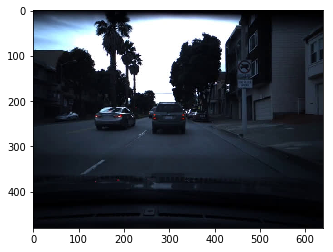

original2 image shape: (480, 640, 3)


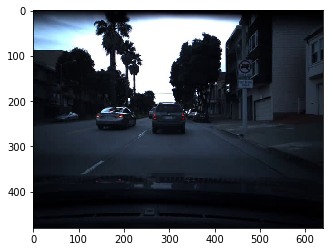

processed1 image shape: (66, 220, 3)


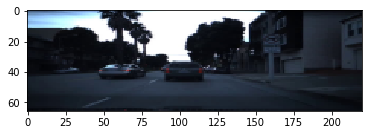

processed2 image shape: (66, 220, 3)


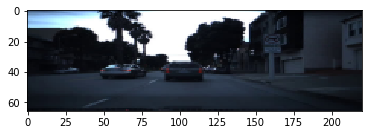

flow image(only ang): (66, 220, 3)


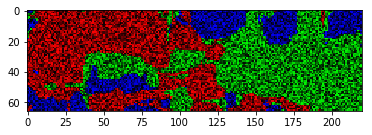

flow image(only mag): (66, 220, 3)


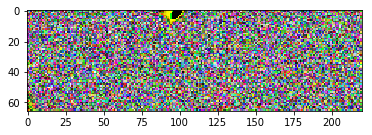

flow image(only saturation): (66, 220, 3)


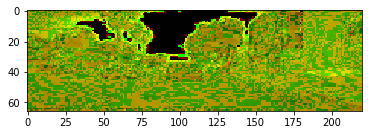

rgb that gets fed to NN image: (66, 220, 3)


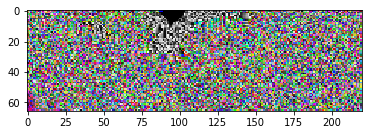

original1 image shape: (480, 640, 3)


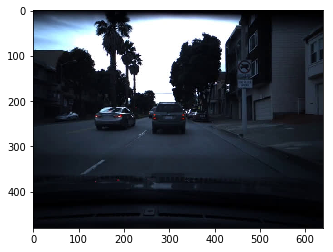

original2 image shape: (480, 640, 3)


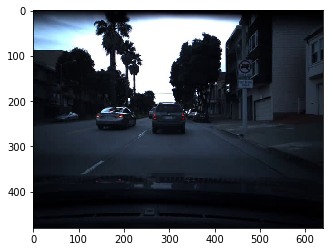

processed1 image shape: (66, 220, 3)


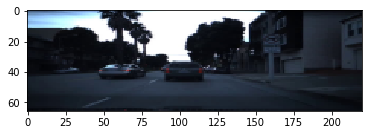

processed2 image shape: (66, 220, 3)


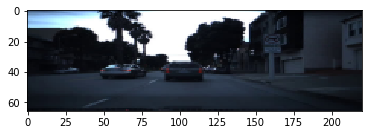

flow image(only ang): (66, 220, 3)


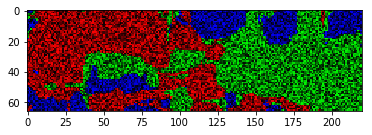

flow image(only mag): (66, 220, 3)


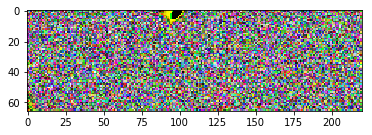

flow image(only saturation): (66, 220, 3)


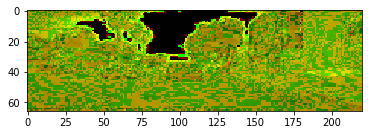

rgb that gets fed to NN image: (66, 220, 3)


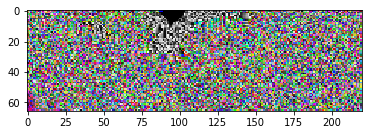

original1 image shape: (480, 640, 3)


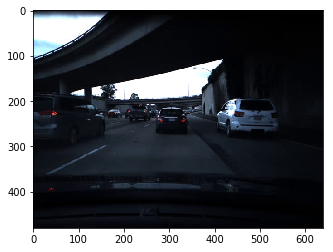

original2 image shape: (480, 640, 3)


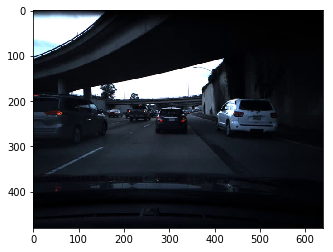

processed1 image shape: (66, 220, 3)


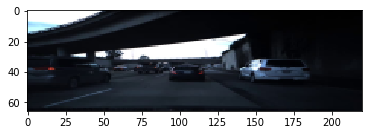

processed2 image shape: (66, 220, 3)


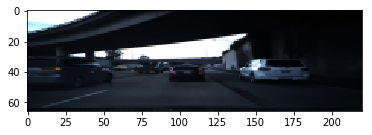

flow image(only ang): (66, 220, 3)


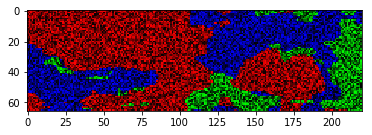

flow image(only mag): (66, 220, 3)


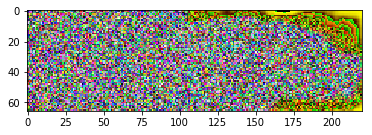

flow image(only saturation): (66, 220, 3)


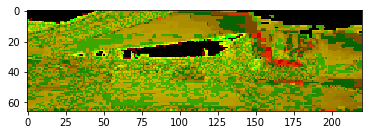

rgb that gets fed to NN image: (66, 220, 3)


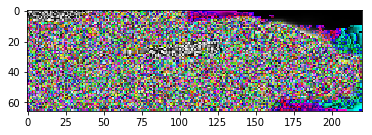

original1 image shape: (480, 640, 3)


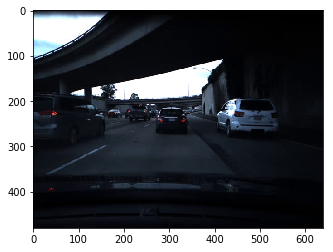

original2 image shape: (480, 640, 3)


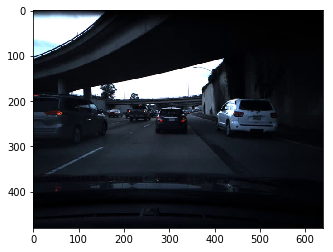

processed1 image shape: (66, 220, 3)


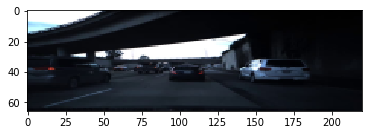

processed2 image shape: (66, 220, 3)


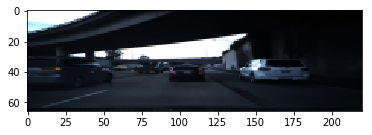

flow image(only ang): (66, 220, 3)


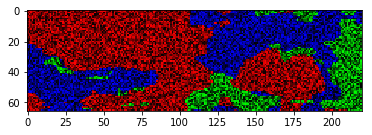

flow image(only mag): (66, 220, 3)


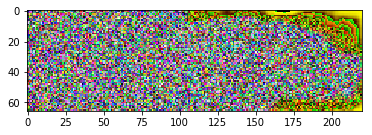

flow image(only saturation): (66, 220, 3)


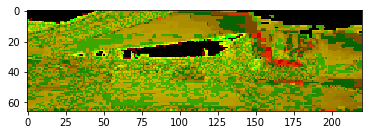

rgb that gets fed to NN image: (66, 220, 3)


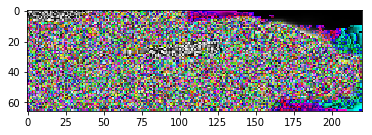

original1 image shape: (480, 640, 3)


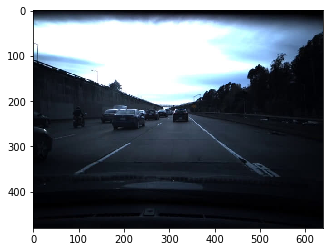

original2 image shape: (480, 640, 3)


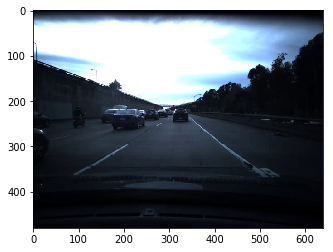

processed1 image shape: (66, 220, 3)


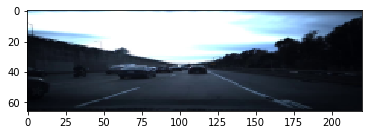

processed2 image shape: (66, 220, 3)


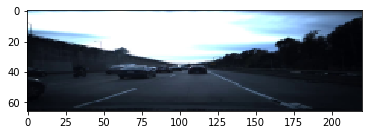

flow image(only ang): (66, 220, 3)


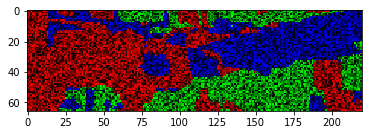

flow image(only mag): (66, 220, 3)


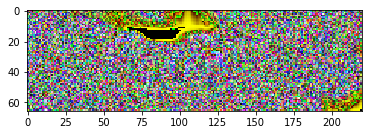

flow image(only saturation): (66, 220, 3)


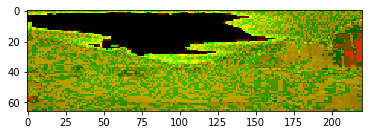

rgb that gets fed to NN image: (66, 220, 3)


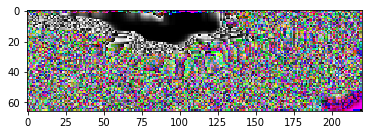

original1 image shape: (480, 640, 3)


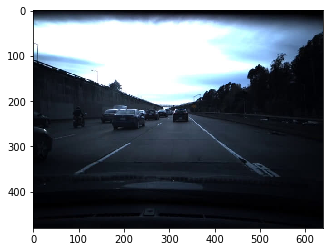

original2 image shape: (480, 640, 3)


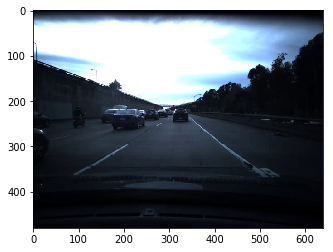

processed1 image shape: (66, 220, 3)


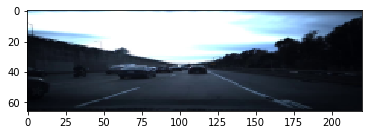

processed2 image shape: (66, 220, 3)


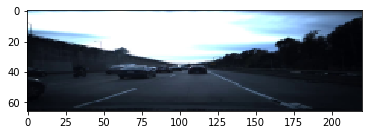

flow image(only ang): (66, 220, 3)


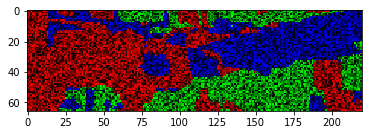

flow image(only mag): (66, 220, 3)


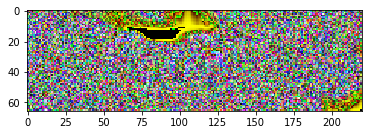

flow image(only saturation): (66, 220, 3)


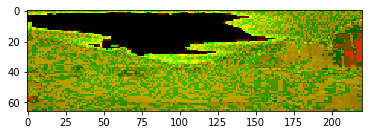

rgb that gets fed to NN image: (66, 220, 3)


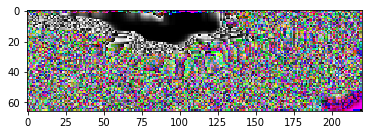

original1 image shape: (480, 640, 3)


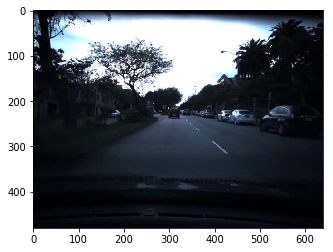

original2 image shape: (480, 640, 3)


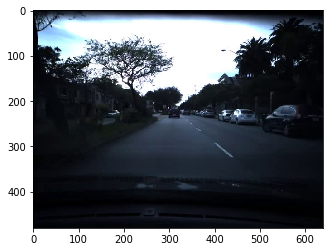

processed1 image shape: (66, 220, 3)


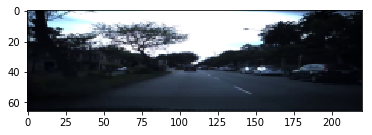

processed2 image shape: (66, 220, 3)


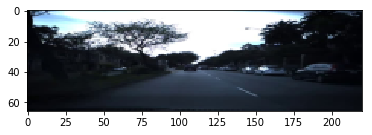

flow image(only ang): (66, 220, 3)


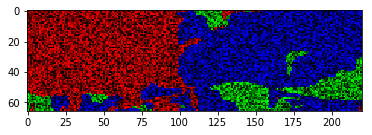

flow image(only mag): (66, 220, 3)


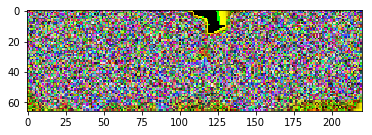

flow image(only saturation): (66, 220, 3)


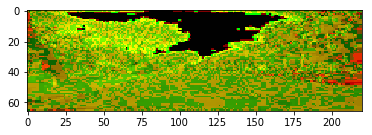

rgb that gets fed to NN image: (66, 220, 3)


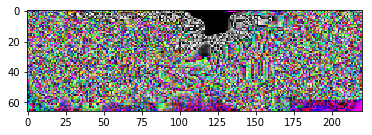

original1 image shape: (480, 640, 3)


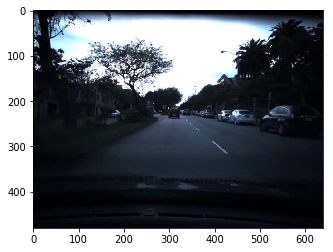

original2 image shape: (480, 640, 3)


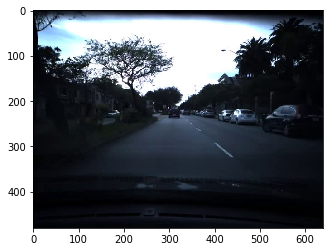

processed1 image shape: (66, 220, 3)


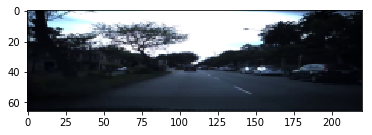

processed2 image shape: (66, 220, 3)


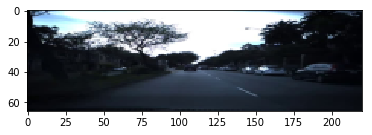

flow image(only ang): (66, 220, 3)


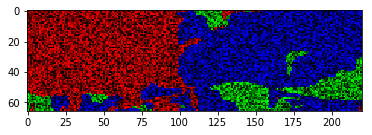

flow image(only mag): (66, 220, 3)


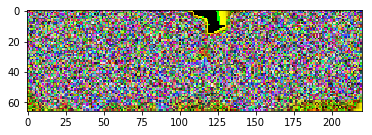

flow image(only saturation): (66, 220, 3)


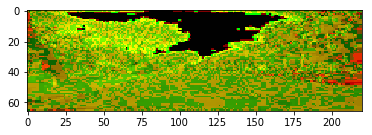

rgb that gets fed to NN image: (66, 220, 3)


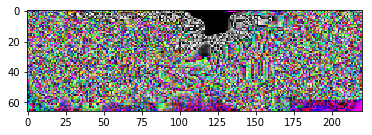

In [304]:
for idx, (rgb_batch, speed_batch) in enumerate(valid_generator):
    if idx ==10 :
        break
    #print(rgb_batch.shape)